<img width="700" src="https://github.com/AllenDowney/ThinkDSP/raw/master/code/fourth_wave.png">

# In Search of the Fourth Wave

### Allen Downey

Olin College

[DSP Online Conference](https://www.dsponlineconference.com/)

Copyright 2020 Allen B. Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

Run this notebook

[tinyurl.com/mysterywave](https://tinyurl.com/mysterywave)

When I was working on [*Think DSP*](https://greenteapress.com/thinkdsp), I encountered a small mystery.  

As you might know:

* A sawtooth wave contains harmonics at integer multiples of the fundamental frequency, and

* Their amplitudes drop off in proportion to $1/f$.  

* A square wave contains only odd multiples of the fundamental, but 

* They also drop off like $1/f$.  

* A triangle wave also contains only odd multiples, 

* But they drop off like $1/f^2$.

Which suggests that there's a simple waveform that 

* Contains all integer multiples (like a sawtooth) and 

* Drops off like $1/f^2$ (like a triangle wave).  

Let's find out what it is.

In this talk, I'll 

* Suggest four ways we can find the mysterious fourth wave.

* Demonstrate using tools from SciPy, NumPy and Pandas, and
  

And a tour of DSP and the topics in *Think DSP*.

I'm a professor of Computer Science at Olin College.

Author of *Think Python*, *Think Bayes*, and *Think DSP*.

And *Probably Overthinking It*, a blog about Bayesian probability and statistics.

Web page: [allendowney.com](http://allendowney.com)

Twitter: @allendowney

This talk is a Jupyter notebook.

[You can read it here](https://nbviewer.jupyter.org/github/AllenDowney/ThinkDSP/blob/master/code/fourth_wave.ipynb).

[And run it here](https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/master/code/fourth_wave.ipynb).

Here are the libraries we'll use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

And a convenience function for decorating figures.

In [2]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like

    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties

    https://matplotlib.org/api/axes_api.html

    In addition, you can use `legend=False` to suppress the legend.

    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [3]:
def legend(**options):
    """Draws a legend only if there is at least one labeled item.

    options are passed to plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.plt.legend.html

    """
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

## Basic waveforms

We'll start with the basic waveforms:

* sawtooth, 

* triangle, and 

* square.

Sampled at CD audio frame rate.

In [4]:
framerate = 44100        # samples per second
dt = 1 / framerate       # seconds per sample

At equally-spaced times from 0 to `duration`.

In [5]:
duration = 0.005                    # seconds
ts = np.arange(0, duration, dt)     # seconds

We'll work with signals at 1000 Hz.  

The number of complete cycles is $f t$.

In [6]:
freq = 1000              # cycles per second (Hz)
cycles = freq * ts       # cycles

In 0.005 seconds, a 1000 Hz signal completes 5 cycles.

In [7]:
np.max(cycles)

4.988662131519274

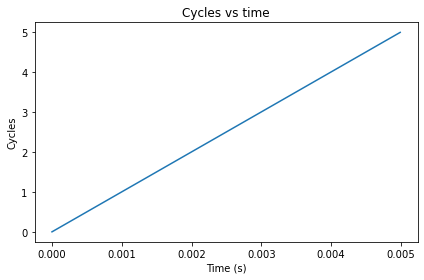

In [8]:
plt.plot(ts, cycles)

decorate(xlabel='Time (s)',
         ylabel='Cycles',
         title='Cycles vs time')

`wrap` uses `modf` to compute the fraction part of the number of cycles.

In [9]:
def wrap(cycles):
    frac, _ = np.modf(cycles)
    return frac

If we apply `wrap` to `cycles`, the result is a sawtooth wave.

I subtract off `0.5` so the mean of the signal is 0.

In [10]:
ys = wrap(cycles) - 0.5
ys.mean()

0.003380839515293344

Here's what it looks like.

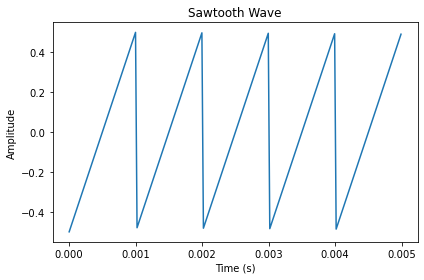

In [76]:
plt.plot(ts, ys)

decorate(xlabel='Time (s)',
         ylabel='Amplitude',
         title='Sawtooth Wave')

If we take the absolute value of `ys`, the result is a triangle wave.

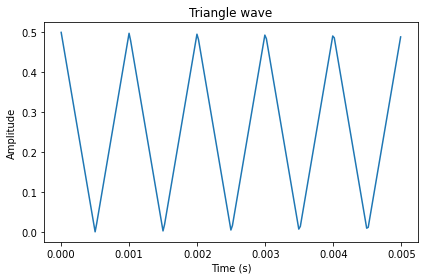

In [12]:
plt.plot(ts, np.abs(ys))

decorate(xlabel='Time (s)',
         ylabel='Amplitude',
         title='Triangle wave')

And if we take just the sign of `ys`, the result is a square wave.

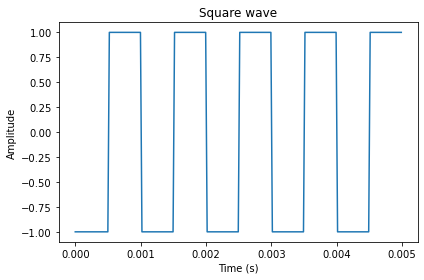

In [13]:
plt.plot(ts, np.sign(ys))

decorate(xlabel='Time (s)',
         ylabel='Amplitude',
         title='Square wave')

Think of `abs` as magnitude and `sign` as direction

* The triangle is the magnitude of a sawtooth.

* The square wave is the direction of a sawtooth.

## One function to make them all

`make_wave` contains the parts these waves have in common.

In [14]:
def make_wave(func, duration, freq):
    """Make a signal.
    
    func: function that takes cycles and computes ys
    duration: length of the wave in time
    """
    ts = np.arange(0, duration, dt)
    cycles = freq * ts    
    ys = func(cycles)
    
    ys = unbias(normalize(ys))
    series = pd.Series(ys, ts)
    return series

`normalize` scales the wave between 0 and 1,

`unbias` shifts it so the mean is 0.

In [15]:
def normalize(ys):
    low, high = np.min(ys), np.max(ys)
    return (ys - low) / (high - low)

def unbias(ys):
    return ys - ys.mean()

Why use a `Series`?

`Series` is like two arrays:

* An index, and

* Corresponding value.

Natural representation of correspondence:

* From time to amplitude.

* From frequency to complex amplitude.

We'll use `plot_wave` to plot a short segment of a wave.

In [16]:
def plot_wave(wave, title=''):
    segment = wave[0:0.01]
    segment.plot()
    decorate(xlabel='Time (s)',
             ylabel='Amplitude',
             title=title)

Now we can define `sawtooth_func` to compute the sawtooth wave.

In [17]:
def sawtooth_func(cycles):
    ys = wrap(cycles) - 0.5
    return ys

And pass it as an argument to `make_wave`:

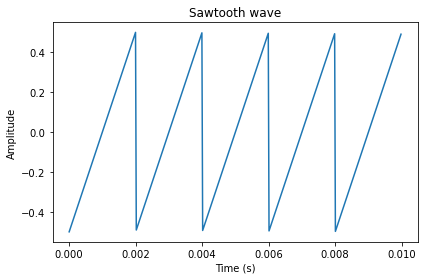

In [18]:
sawtooth_wave = make_wave(sawtooth_func, duration=0.01, freq=500)
plot_wave(sawtooth_wave, title='Sawtooth wave')

Same with `triangle_func`.

In [19]:
def triangle_func(cycles):
    ys = wrap(cycles) - 0.5
    return np.abs(ys)

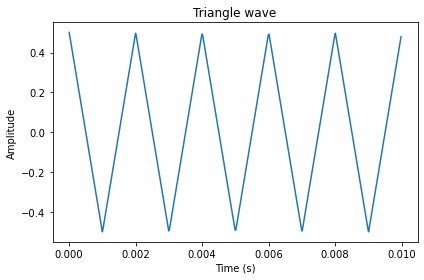

In [20]:
triangle_wave = make_wave(triangle_func, duration=0.01, freq=500)
plot_wave(triangle_wave, title='Triangle wave')

And `square_func`.

In [21]:
def square_func(cycles):
    ys = wrap(cycles) - 0.5
    return np.sign(ys)

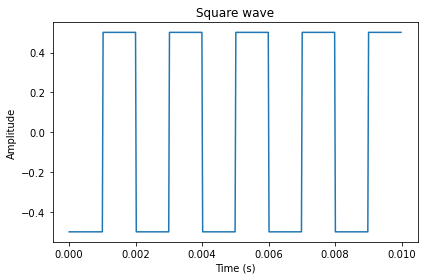

In [22]:
square_wave = make_wave(square_func, duration=0.01, freq=500)
plot_wave(square_wave, title='Square wave')

## Spectrum

Now let's see what the spectrums look like for these waves.


In [23]:
def make_spectrum(wave):
    n = len(wave)
    hs = np.fft.rfft(wave)         # amplitudes
    fs = np.fft.rfftfreq(n, dt)    # frequencies

    series = pd.Series(hs, fs)
    return series

`make_spectrum` uses NumPy to compute the real FFT of the wave:

* `hs` contains the complex amplitudes, and

* `fs` contains the corresponding frequencies.

Pandas `Series` represents correspondence between frequencies and complex amplitudes.

Use `abs` to compute magnitude of complex amplitudes and 
plot them as a function of `fs`:

In [24]:
def plot_spectrum(spectrum, title=''):
    spectrum.abs().plot()
    decorate(xlabel='Frequency (Hz)',
             ylabel='Magnitude',
             title=title)

I'll use a sinusoid to test `make_spectrum`.

In [25]:
def sinusoid_func(cycles):
    return np.cos(2 * np.pi * cycles)

Now we can use `make_wave` to make a sinusoid.

In [26]:
sinusoid_wave = make_wave(sinusoid_func, duration=0.5, freq=freq)

And `make_spectrum` to compute its spectrum.

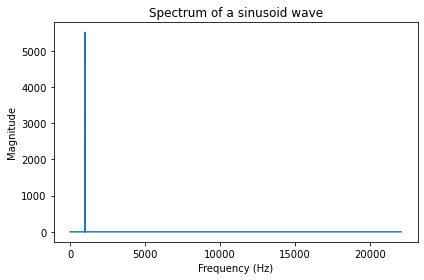

In [27]:
sinusoid_spectrum = make_spectrum(sinusoid_wave)
plot_spectrum(sinusoid_spectrum, 
              title='Spectrum of a sinusoid wave')

A sinusoid only contains one frequency component.

As contrasted with the spectrum of a sawtooth wave, which looks like this.

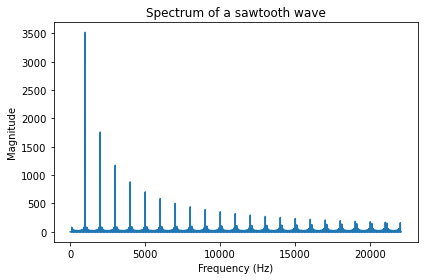

In [28]:
sawtooth_wave = make_wave(sawtooth_func, duration=0.5, freq=freq)
sawtooth_spectrum = make_spectrum(sawtooth_wave)
plot_spectrum(sawtooth_spectrum, 
              title='Spectrum of a sawtooth wave')

The largest magnitude is at 1000 Hz, but the signal also contains components at every integer multiple of the fundamental frequency.

Here's the spectrum of a square wave with the same fundamental frequency.  

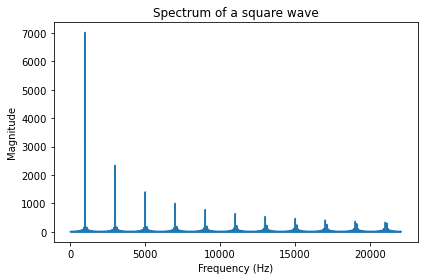

In [29]:
square_wave = make_wave(square_func, duration=0.5, freq=freq)
square_spectrum = make_spectrum(square_wave)
plot_spectrum(square_spectrum, 
              title='Spectrum of a square wave')

The spectrum of the square wave has only odd harmonics.

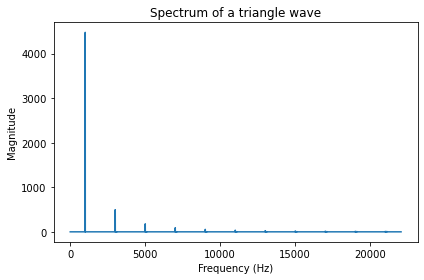

In [30]:
triangle_wave = make_wave(triangle_func, duration=0.5, freq=freq)
triangle_spectrum = make_spectrum(triangle_wave)
plot_spectrum(triangle_spectrum, 
              title='Spectrum of a triangle wave')

The spectrum of the triangle wave has odd harmonics only.

But they drop off more quickly.


## Sound


`make_audio` makes an IPython `Audio` object we can use to play a wave.

In [31]:
from IPython.display import Audio

def make_audio(wave):
    """Makes an IPython Audio object.
    """
    return Audio(data=wave, rate=framerate)

Dropping to 500 Hz to spare your ears.

In [32]:
freq = 500

In [33]:
sinusoid_wave = make_wave(sinusoid_func, duration=0.5, freq=freq)
make_audio(sinusoid_wave)

In [34]:
triangle_wave = make_wave(triangle_func, duration=0.5, freq=freq)
make_audio(triangle_wave)

In [35]:
sawtooth_wave = make_wave(sawtooth_func, duration=0.5, freq=freq)
make_audio(sawtooth_wave)

In [36]:
square_wave = make_wave(square_func, duration=0.5, freq=freq)
make_audio(square_wave)

## Dropoff

Let's see how the spectrums depend on $f$.

In [37]:
def plot_over_f(spectrum, freq, exponent):
    fs = spectrum.index
    hs = 1 / fs**exponent

    over_f = pd.Series(hs, fs)
    over_f[fs<freq] = np.nan
    over_f *= np.abs(spectrum[freq]) / over_f[freq]
    over_f.plot(color='gray')

In [38]:
freq = 500

In [39]:
sawtooth_wave = make_wave(func=sawtooth_func, 
                          duration=0.5, freq=freq)
sawtooth_spectrum = make_spectrum(sawtooth_wave)

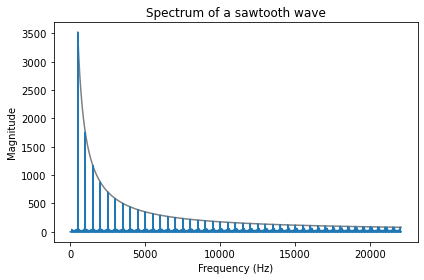

In [40]:
plot_over_f(sawtooth_spectrum, freq, 1)
plot_spectrum(sawtooth_spectrum, 
              title='Spectrum of a sawtooth wave')

In [41]:
square_wave = make_wave(func=square_func, 
                        duration=0.5, freq=freq)
square_spectrum = make_spectrum(square_wave)

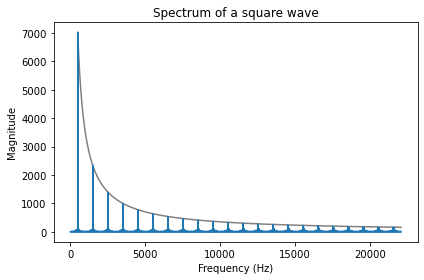

In [42]:
plot_over_f(square_spectrum, freq, 1)
plot_spectrum(square_spectrum, 
              title='Spectrum of a square wave')

In [43]:
triangle_wave = make_wave(func=triangle_func, 
                          duration=0.5, freq=freq)
triangle_spectrum = make_spectrum(triangle_wave)

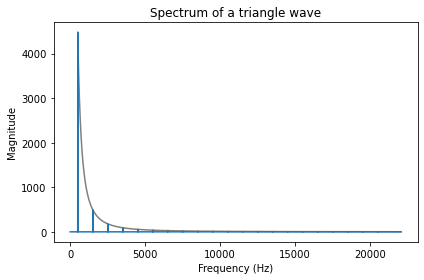

In [44]:
plot_over_f(triangle_spectrum, freq, 2)
plot_spectrum(triangle_spectrum, 
              title='Spectrum of a triangle wave')

In [45]:
def text(x, y, text):
    transform = plt.gca().transAxes
    plt.text(x, y, text, transform=transform)

In [46]:
def plot_four_spectrums(fourth=None):
    plt.figure(figsize=(9, 6))

    plt.subplot(2, 2, 1)
    plot_over_f(square_spectrum, freq, 1)
    plot_spectrum(square_spectrum, 
              title='Spectrum of a square wave')
    text(0.3, 0.5, 'Odd harmonics, $1/f$ dropoff.')

    plt.subplot(2, 2, 2)
    plot_over_f(triangle_spectrum, freq, 2)
    plot_spectrum(triangle_spectrum, 
              title='Spectrum of a triangle wave')
    text(0.3, 0.5, 'Odd harmonics, $1/f^2$ dropoff.')

    plt.subplot(2, 2, 3)
    plot_over_f(sawtooth_spectrum, freq, 1)
    plot_spectrum(sawtooth_spectrum, 
              title='Spectrum of a sawtooth wave')
    text(0.3, 0.5, 'All harmonics, $1/f$ dropoff.')


    plt.subplot(2, 2, 4)
    text(0.3, 0.5, 'All harmonics, $1/f^2$ dropoff.')
    if fourth is not None:
        plot_over_f(fourth, freq, 2)
        plot_spectrum(fourth, 
              title='Spectrum of a parabola wave')
    else: 
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()

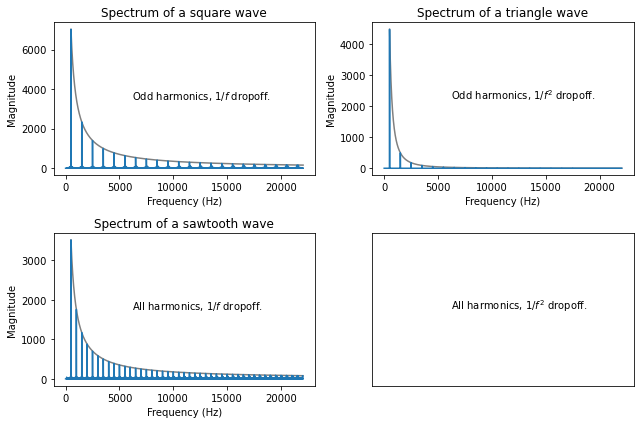

In [47]:
plot_four_spectrums()

## Method 1: Filtering

One option is to start with a sawtooth wave, which has all of the harmonics we need.

In [48]:
sawtooth_wave = make_wave(sawtooth_func, duration=0.5, freq=freq)
sawtooth_spectrum = make_spectrum(sawtooth_wave)

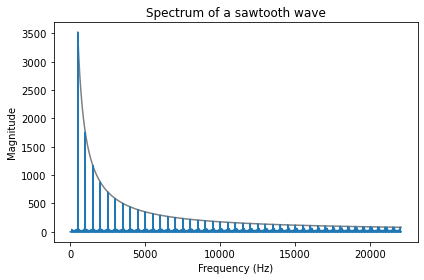

In [49]:
plot_over_f(sawtooth_spectrum, freq, 1)
plot_spectrum(sawtooth_spectrum, 
              title='Spectrum of a sawtooth wave')

And filter it by dividing through by $f$.

In [50]:
fs = sawtooth_spectrum.index
filtered_spectrum = sawtooth_spectrum / fs
filtered_spectrum[0:400] = 0

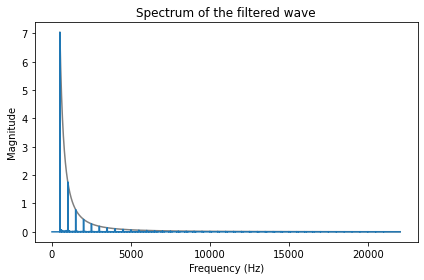

In [51]:
plot_over_f(filtered_spectrum, freq, 2)
plot_spectrum(filtered_spectrum, 
              title='Spectrum of the filtered wave')

Now we can convert from spectrum to wave.

In [52]:
def make_wave_from_spectrum(spectrum):
    ys = np.fft.irfft(spectrum)
    n = len(ys)
    ts = np.arange(n) * dt

    series = pd.Series(ys, ts)
    return series

In [53]:
filtered_wave = make_wave_from_spectrum(filtered_spectrum)

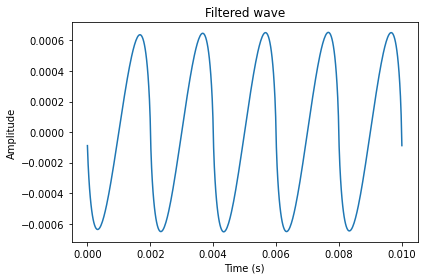

In [54]:
plot_wave(filtered_wave, title='Filtered wave')

It's an interesting shape, but not easy to see what its functional form is.

## Method 2: Additive synthesis

Another approach is to add up a series of cosine signals with the right frequencies and amplitudes.

In [55]:
fundamental = 500
nyquist = framerate / 2
freqs = np.arange(fundamental, nyquist, fundamental)
amps = 1 / freqs**2

In [56]:
total = 0
for f, amp in zip(freqs, amps):
    component = amp * make_wave(sinusoid_func, 0.5, f)
    total += component

In [57]:
synth_wave = unbias(normalize(total))
synth_spectrum = make_spectrum(synth_wave)

Here's what the spectrum looks like:

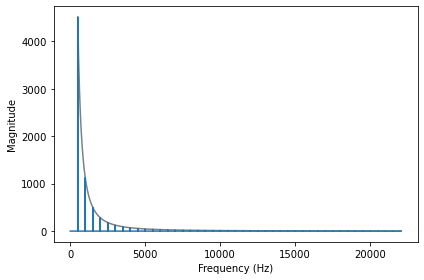

In [58]:
plot_over_f(synth_spectrum, freq, 2)
plot_spectrum(synth_spectrum)

And here's what the waveform looks like.

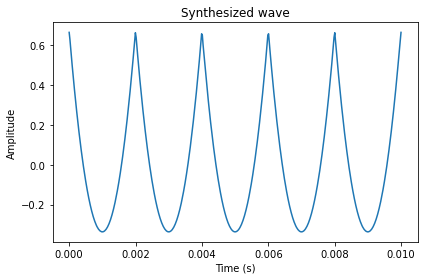

In [59]:
plot_wave(synth_wave, title='Synthesized wave')

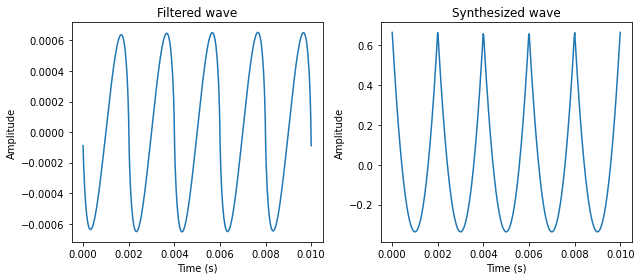

In [60]:
plt.figure(figsize=(9,4))
plt.subplot(1, 2, 1)
plot_wave(filtered_wave, title='Filtered wave')
plt.subplot(1, 2, 2)
plot_wave(synth_wave, title='Synthesized wave')

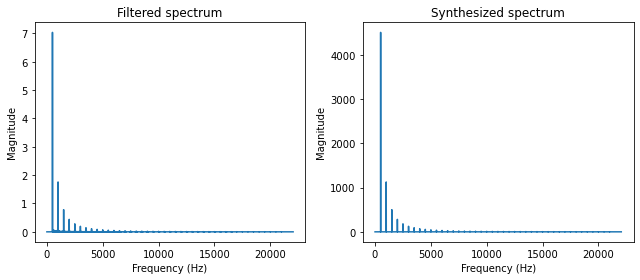

In [61]:
plt.figure(figsize=(9,4))
plt.subplot(1, 2, 1)
plot_spectrum(filtered_spectrum, title='Filtered spectrum')
plt.subplot(1, 2, 2)
plot_spectrum(synth_spectrum, title='Synthesized spectrum')

In [62]:
make_audio(synth_wave)

In [63]:
make_audio(filtered_wave)

What we hear depends on the magnitudes, not their phase.

Mostly.

[Autocorrelation and the case of the missing fundamental](https://www.dsprelated.com/showarticle/909.php)

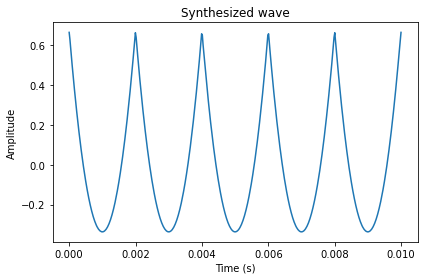

In [64]:
plot_wave(synth_wave, title='Synthesized wave')

## Method 3: Parabolas

In [65]:
def parabola_func(cycles):
    ys = wrap(cycles) - 0.5
    return ys**2

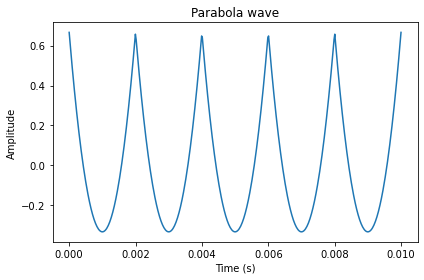

In [66]:
parabola_wave = make_wave(parabola_func, 0.5, freq)
plot_wave(parabola_wave, title='Parabola wave')

Does it have the right harmonics?

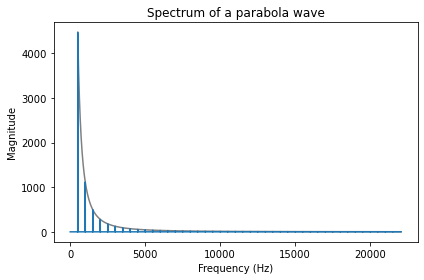

In [67]:
parabola_spectrum = make_spectrum(parabola_wave)
plot_over_f(parabola_spectrum, freq, 2)
plot_spectrum(parabola_spectrum, 
              title='Spectrum of a parabola wave')

We looked at the waveform and guessed it's a parabola.

So we made a parabola and it seems to work.

Satisfied?

There's another way to get there:

The integral property of the Fourier transform.

## Method 4: Integration

The basis functions of the FT are the complex exponentials:

$e^{2 \pi i f t}$

And we know how to integrate them.



$\int e^{2 \pi i f t}~dt = \frac{1}{2 \pi i f}~e^{2 \pi i f t}$


Integration in the time domain is a $1/f$ filter in the frequency domain.

When we applied a $1/f$ filter to the spectrum of the sawtooth,

We were integrating in the time domain.

Which we can approximate with `cumsum`.

In [68]:
integrated_wave = unbias(normalize(sawtooth_wave.cumsum()))

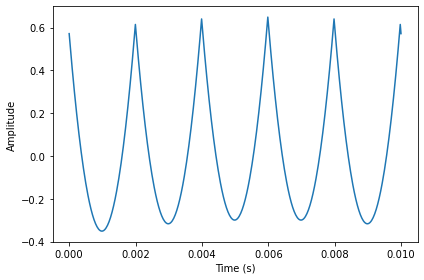

In [69]:
plot_wave(integrated_wave)

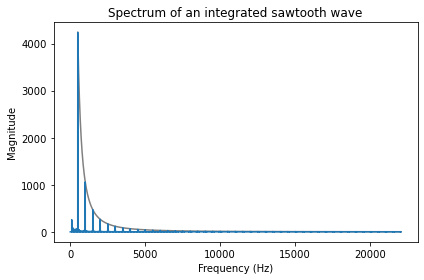

In [70]:
integrated_spectrum = make_spectrum(integrated_wave)

plot_over_f(integrated_spectrum, freq, 2)
plot_spectrum(integrated_spectrum, 
              title='Spectrum of an integrated sawtooth wave')

Summary

In [71]:
def plot_four_waves(fourth=None):

    plt.figure(figsize=(9, 6))

    plt.subplot(2, 2, 1)
    plot_wave(square_wave, 
          title='Square wave')

    plt.subplot(2, 2, 2)
    plot_wave(triangle_wave, 
          title='Triangle wave')

    plt.subplot(2, 2, 3)
    plot_wave(sawtooth_wave, 
          title='Sawtooth wave')
    
    if fourth is not None:
        plt.subplot(2, 2, 4)
        plot_wave(parabola_wave, 
          title='Parabola wave')


    plt.tight_layout()

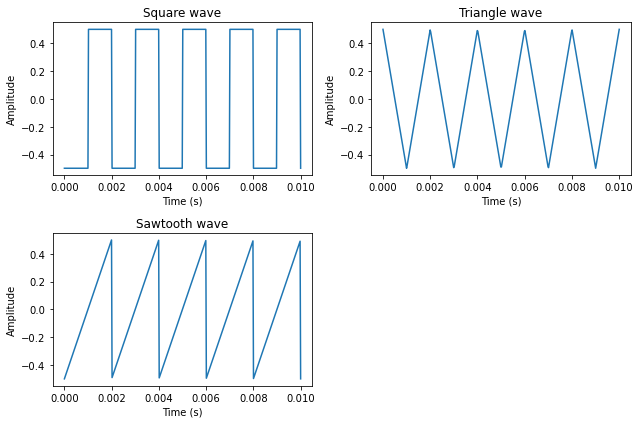

In [72]:
plot_four_waves()

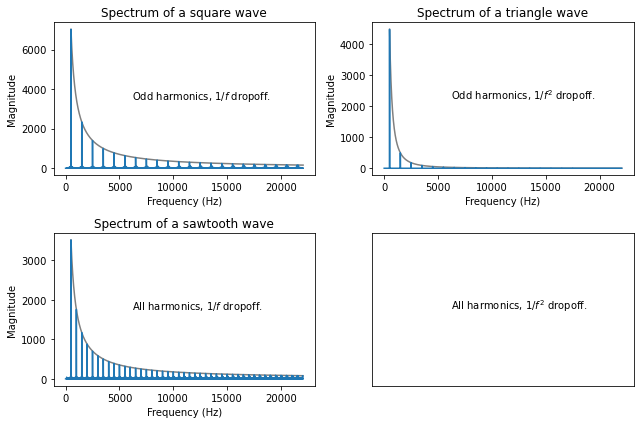

In [73]:
plot_four_spectrums()

Four ways:

* $1/f$ filter

* Additive synthesis

* Parabola waveform

* Integrated sawtooth

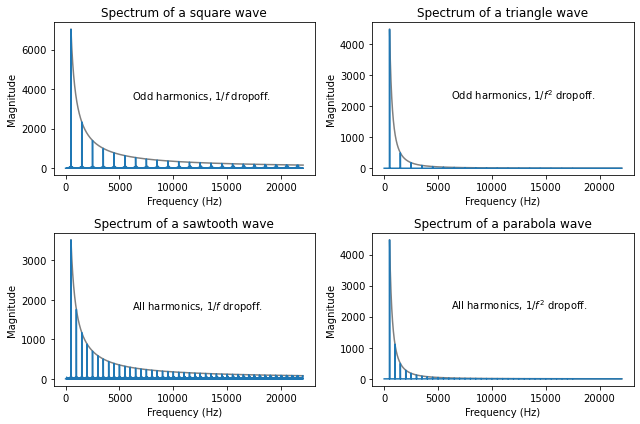

In [74]:
plot_four_spectrums(parabola_spectrum)

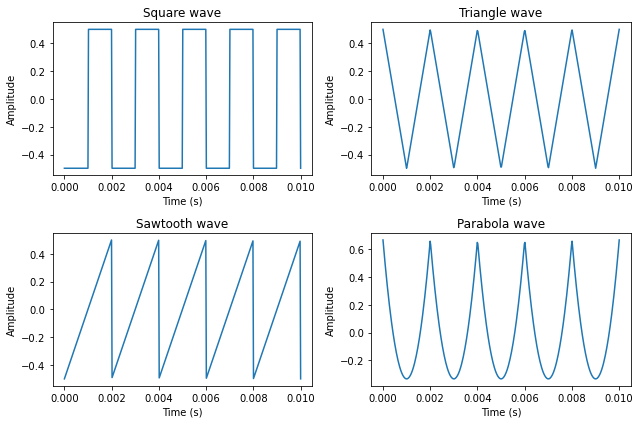

In [75]:
plot_four_waves(parabola_wave)

What have we learned?

Most of [*Think DSP*](https://greenteapress.com/wp/think-dsp/).

At least as an introduction.

Discrete Fourier transform as correspondence between a wave and its spectrum

[Chapter 1](http://greenteapress.com/thinkdsp/html/thinkdsp002.html)

Harmonic structure of sound

[Chapter 2](http://greenteapress.com/thinkdsp/html/thinkdsp003.html)

Lead in to chirps (variable frequency waves)

[Chapter 3](http://greenteapress.com/thinkdsp/html/thinkdsp004.html)

Lead in to pink noise, which drops off like $1/f^{\beta}$

[Chapter 4](http://greenteapress.com/thinkdsp/html/thinkdsp005.html)

Additive synthesis

[Chapter 7](http://greenteapress.com/thinkdsp/html/thinkdsp008.html)

Integral property of the Fourier transform

[Chapter 9](http://greenteapress.com/thinkdsp/html/thinkdsp010.html)

Convolution in the time domain corresponds to multiplication in the frequency domain.

[Chapter 10](http://greenteapress.com/thinkdsp/html/thinkdsp011.html)

Thank you!

Web page: allendowney.com

Twitter: @allendowney

This notebook: [tinyurl.com/mysterywave](https://tinyurl.com/mysterywave)